# Does a 5 layer neural network on the data in cleaned_spotify.csv

In [ ]:
%pip install pandas numpy lightning scikit-learn torchmetrics matplotlib optuna

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-11.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 48.5 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 54.0 MB/s eta 0:00:00
Using cached kiwisolver-1.4.7-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Using cached pillow-11.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.4 MB)
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
# imports
import os
os.environ['PJRT_DEVICE'] = "GPU"
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from typing import cast, List
from sklearn.decomposition import PCA
import torch._dynamo
torch._dynamo.config.suppress_errors = True
import torchmetrics as tm
import optuna
import plotly
import plotly.express as px

# Model

The model predicts track genre with respect to all other variables except for numeric ones, album name, and track name.

We made sure to one-hot encode the track genre and standardize and mean-center the data.

The model is a 3 layer neural network with 1 hidden layer. The hidden layer size and learning rate are kept as variable hyperparameters, with defaults being 0.001 and 32 (and optimimums 0.005 and 91). The hidden layer uses the ReLU activation function and the output layer uses softmax, as the output is a one-hot encoded mutli-class classification.

The model is trained using the cross entropy loss function using mini-batched gradient descent of batch size 32. It uses the pytorch lightning package for acceleration and optimization, which handles backpropagation. 

The model is assessed by cross entropy, and accuracy is reported as a more human-readable metric. 

# Data loading and feature selection

In [ ]:
# Load the cleaned data
data = pd.read_csv('csv_outputs/cleaned_spotify.csv')

# Split the data into training and testing sets
prediction = 'track_genre'
categorical_columns = ['track_name', 'artists', 'album_name', 'track_name']
X = data.drop(columns=[prediction, 'track_id', *categorical_columns])
y = data[prediction]

# one hot encode the y values
y = pd.get_dummies(y)

# Normalize the data
X = (X - X.mean()) / X.std()

In [80]:
# split into train and test
X_split, X_test, y_split, y_test = cast(
    List[pd.DataFrame],
    train_test_split(X, y, test_size=0.2, random_state=42)
)

X_train, X_val, y_train, y_val = cast(
    List[pd.DataFrame],train_test_split(
        X_split, y_split,
        test_size=0.25,
        random_state=42
    )
)

# Convert the data to tensors
X_train = torch.tensor(X_train.to_numpy(np.float32), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(np.float32), dtype=torch.float32)
X_val = torch.tensor(X_val.to_numpy(np.float32), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(np.float32), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(np.float32), dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(np.float32), dtype=torch.float32)

In [76]:
# Create a PyTorch dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

# Create a PyTorch dataloader (to enabled batch training)
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the model
class Model(pl.LightningModule):
    def __init__(
            self,
            # hyperparameters
            lr = 0.001,
            hidden_size = 32
        ):
        super(Model, self).__init__()
        # the actual model
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, y_train.shape[1]),
            nn.Softmax(dim=1), # For multi-class classification
        )
        self.learning_rate = lr
        self.epoch_metrics = dict()

    def forward(self, x):
        return self.model(x)

    # training loss function (for backpropagation)
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        y = y.argmax(dim=1)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        y = y.argmax(dim=1)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    # used to report error metrics for graphs
    def on_validation_epoch_end(self):
        y_hat = self(X_test)

        with torch.no_grad():
            cross_entropy = F.cross_entropy(y_hat, y_test.argmax(dim=1))
            accuracy = tm.Accuracy(task="multiclass", num_classes=y_test.shape[1])(y_hat, y_test.argmax(dim=1))
            self.epoch_metrics[self.current_epoch] = dict(
                cross_entropy=cross_entropy,
                accuracy=accuracy
            )


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [ ]:
# Hyperparameters, learned from below
lr = 0.005
hidden_size = 91

# Train the model
model = Model(lr, hidden_size)
model.train()

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='cpu',
    default_root_dir="w10checkpoints/",
    accumulate_grad_batches=7
)

ckpt_path=None
# to restore previous session's model parameters
# ckpt_path="./w10checkpoints/lightning_logs/version_15/checkpoints/epoch=9-step=4080.ckpt"
trainer.fit(model, train_dataloader, val_dataloader, ckpt_path=ckpt_path)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 11.9 K | train
---------------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 448.98it/s, v_num=95, val_loss=4.520]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 448.72it/s, v_num=95, val_loss=4.520]


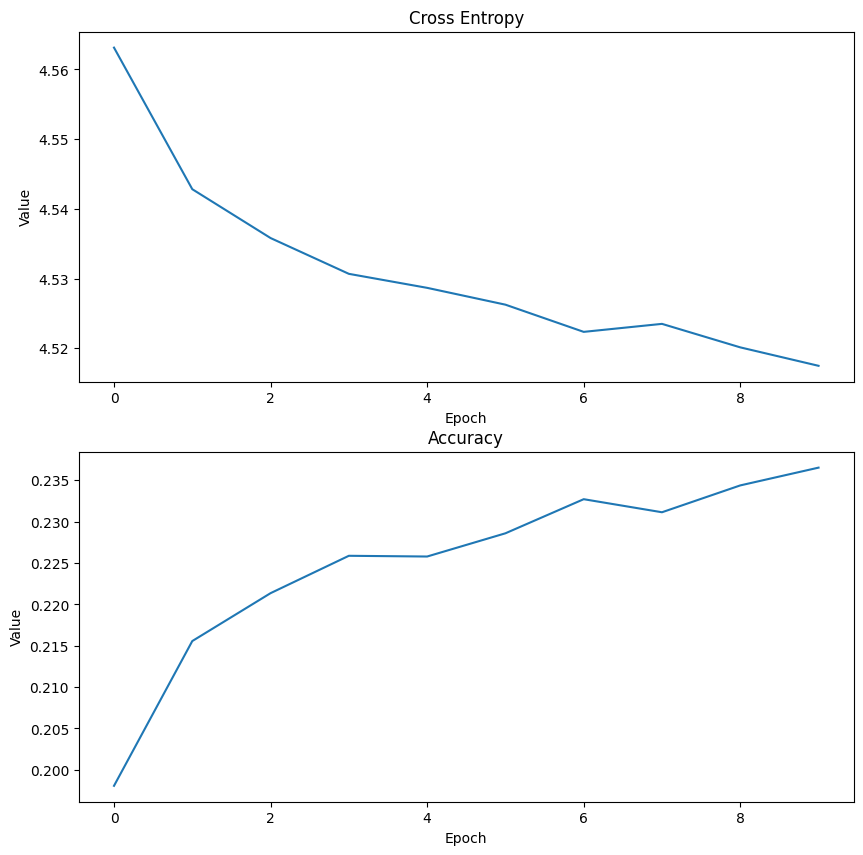

In [82]:
# graph the epoch metrics
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot([m['cross_entropy'] for m in model.epoch_metrics.values()])
ax[0].set_title('Cross Entropy')
ax[1].plot([m['accuracy'] for m in model.epoch_metrics.values()])
ax[1].set_title('Accuracy')
# axes labels
for a in ax:
    a.set_xlabel('Epoch')
    a.set_ylabel('Value')

None


# Learning Hyperparameters
To learn hyperparameters, we trained the model using various hyperparameters (using the optuna library) and chose the one that created lowest loss. The hyperparameters we trained were learning rate and hidden layer size.

In [ ]:
# Choosing hyperparameters
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-8, 1e-2, log=True)
    hidden_size = trial.suggest_int('hidden_size', 8, 128, log=True)

    model = Model(learning_rate, hidden_size)

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='cpu',
        default_root_dir="w10checkpoints/",
        accumulate_grad_batches=7
    )

    trainer.fit(model, train_dataloader, val_dataloader)

    val_loss = trainer.callback_metrics["val_loss"].item()
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Optimum hyperparameters: ", study.best_params["learning_rate"])

The graph below shows how the hyperparameters affect loss.

We can see that lower learning rate did affect loss, though this is likely due to the fixed epoch count.

After 0.05 LR, the loss seemed to increase.

The hidden layer size seemed to have less effect.

Optimum hyperparameters:  {'learning_rate': 0.0052227502858004605, 'hidden_size': 91}


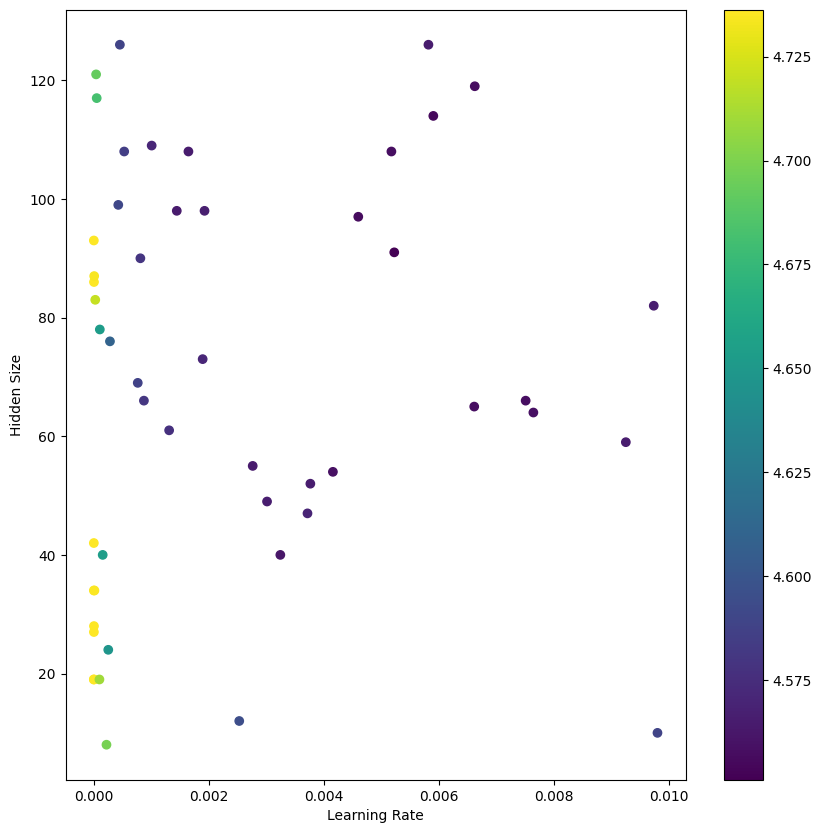

In [ ]:
# plot both the learning rate vs. hidden size with
# the loss as color
# uses matplotlib

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(
    [trial.params["learning_rate"] for trial in study.trials],
    [trial.params["hidden_size"] for trial in study.trials],
    c=[trial.value for trial in study.trials],
    cmap='viridis'
)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Hidden Size')

# legend
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([trial.value for trial in study.trials])
fig.colorbar(sm, ax=ax)


print("Optimum hyperparameters: ", study.best_params)

Text(0, 0.5, 'Loss')

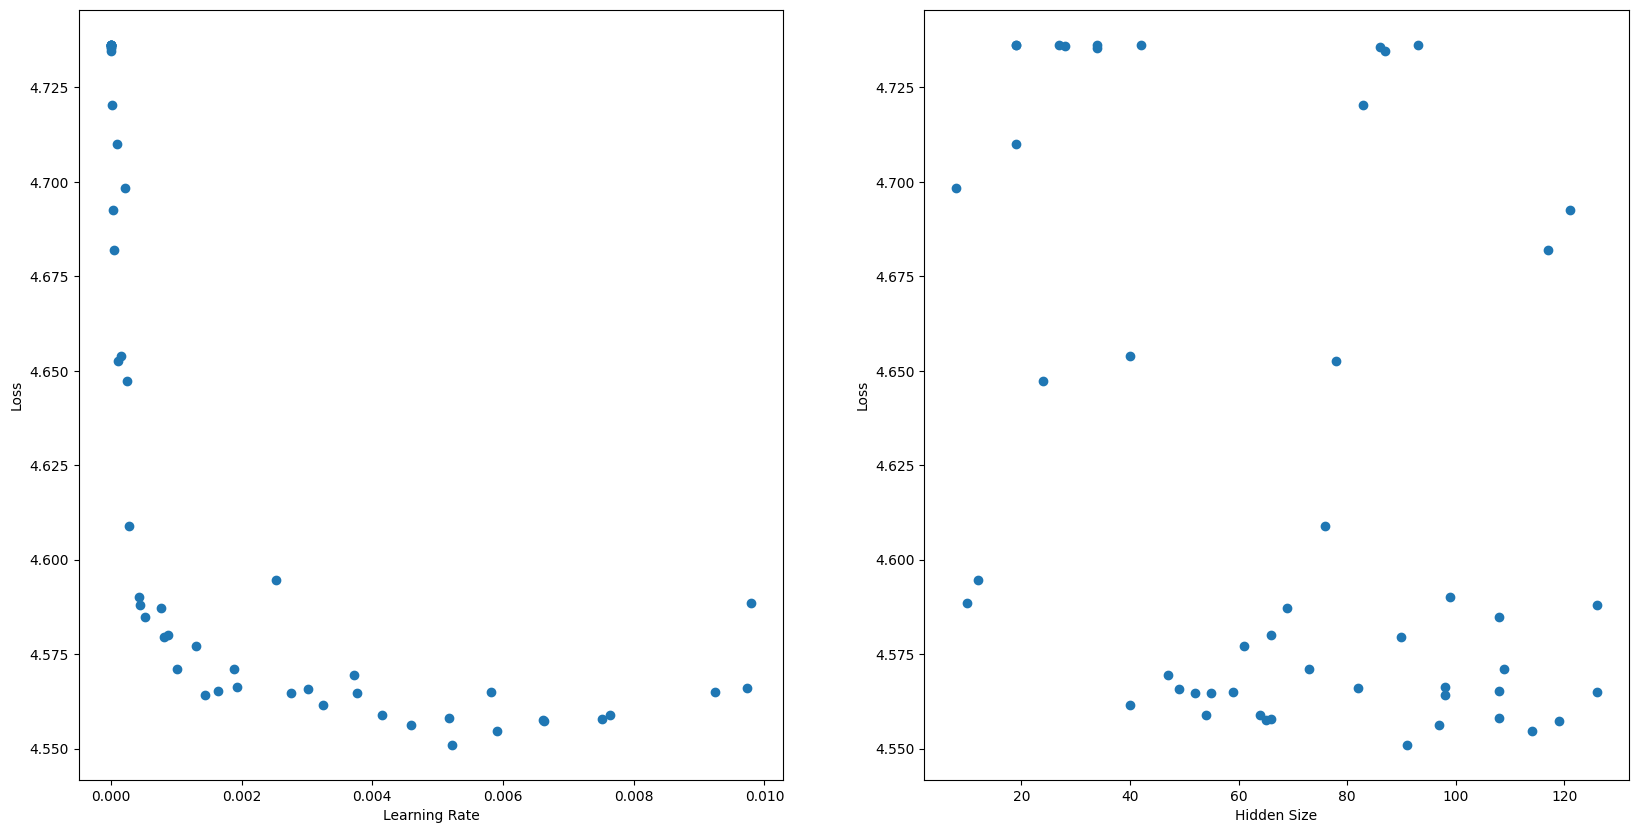

In [96]:
# plots the learning rate vs. loss and hidden size vs. loss

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(
    [trial.params["learning_rate"] for trial in study.trials],
    [trial.value for trial in study.trials]
)
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Loss')

ax[1].scatter(
    [trial.params["hidden_size"] for trial in study.trials],
    [trial.value for trial in study.trials]
)
ax[1].set_xlabel('Hidden Size')
ax[1].set_ylabel('Loss')